https://llama3-2-lightweight.llamameta.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiZDh6czFjYmMyajh0dHJzZ2p0bjZ0czNpIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvbGxhbWEzLTItbGlnaHR3ZWlnaHQubGxhbWFtZXRhLm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyODg2ODk1OH19fV19&Signature=B5agOX4NwKEHv-Ia%7E0wfpuspNTHVfKEtDdTtyrePRhFNzRk4tXgZAcFKUP0H7vatYFX4GGUc3oaAzDe07YYANtA-CBzKMtyNXfjqM9Ki1-eEn9OajIx-5pOgsN93zwgiQEDd5WJRFF6ndGyr3ZfGTUmRNg0GWUqH8v7CLcFWp042G6BtLgFGvBnClFAHje-5E66QvPyKtxKwq4JydYLMQF8htYvsA61toRMch%7EpM0RwtHe8oVi45qNfXJwdG1g8cmY4AZn7tsV7yl1-F1hGZZi7h%7ET%7EZCCbq9NpujVKOCTNz0ml1U9QDtkFMh-9tzmTxJF9JL-CWj-tWxIJ0y6Bpag__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=543367358241664

In [1]:
import gym_agent as ga
from gymnasium.spaces import Dict, Box, Discrete

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from ppo import PPO

AttributeError: module 'gym_agent' has no attribute 'AgentBase'

In [121]:
env = ga.make("MiniGrid-LavaCrossingS9N3-v0", render_mode="rgb_array")

In [122]:
env.observation_space

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function CrossingEnv._gen_mission_lava at 0x7f29f837ede0>, None))

In [127]:
class State_Tfm(ga.Transform):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(7, 7, 3), dtype='uint8')

    def __call__(self, observation):
        return np.flip(observation['image'], axis=1)

In [128]:
env.set_observation_transform(State_Tfm())

In [6]:
class ConvBn(nn.Module):
	'''
	Convolution + BatchNorm + ReLu (+ MaxPool)

	keeping the size of input, if Maxpool, reduce the size by half
	'''
	def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, pool=False) -> None:
		'''
		Convolution + BatchNorm + ReLu (+ MaxPool)

		keeping the size of input, if Maxpool, reduce the size by half
		'''
		super().__init__()
		self.Conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
		self.Bn = nn.BatchNorm2d(out_channels)
		self.act = nn.ReLU(inplace=True)
		
		if pool:
			self.pool = nn.MaxPool2d(2)
		else:
			self.pool = nn.Identity()

	def forward(self, X: torch.Tensor):
		out = self.Conv(X)
		out = self.Bn(out)
		out = self.act(out)
		out = self.pool(out)
		return out

In [83]:
class Policy(ga.BasePolicy):
    def __init__(self, inp_channels, n_action, filters=[64, 128, 256, 512]):
        super().__init__()

        self.encoded = nn.Sequential()

        self.encoded.append(nn.Conv2d(inp_channels, filters[0], 3, 1, 1))
        self.encoded.append(nn.ReLU(True))

        for i in range(1, len(filters)):
            if i == len(filters)-1:
                self.encoded.append(ConvBn(filters[i-1], filters[i]))
                break
            self.encoded.append(ConvBn(filters[i-1], filters[i], pool=True))

        # self.adaptivePool = GlobalHybridPooling()
        self.encoded.append(nn.AdaptiveMaxPool2d((1, 1)))	# 512, n, n		-> 512, 1, 1
        self.encoded.append(nn.Flatten())

        self.actor = nn.Linear(512, n_action)
        self.critic = nn.Linear(512, 1)
    
    def forward(self, X):
        state = X['image']
        direction = X['direction']
        encoded = self.encoded(state)
        
        encoded = torch.cat([encoded, direction], dim=1)

        return F.softmax(self.actor(encoded)), self.critic(encoded)
    
    def action(self, X):
        state = X['image']
        direction = X['direction']
        encoded = self.encoded(state)
        
        encoded = torch.cat([encoded, direction], dim=1)
        return F.softmax(self.actor(encoded))
    
    def value(self, X):
        state = X['image']
        direction = X['direction']
        encoded = self.encoded(state)
        
        encoded = torch.cat([encoded, direction], dim=1)
        return self.critic(encoded)

In [84]:
model = Policy(inp_channels=3, n_action=7, filters=[64, 128, 256, 512])

In [85]:
obs = env.reset()[0]

In [86]:
obs['image'] = torch.randn(1, 3, 7, 7)
obs['direction'] = torch.randn(1, 4)

In [1]:
import matplotlib.pyplot as plt
from minigrid.wrappers import ImgObsWrapper
import gym_agent as ga
import numpy as np

pygame 2.5.2 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [23]:
env = ga.make("MiniGrid-LavaCrossingS9N3-v0", render_mode="rgb_array")

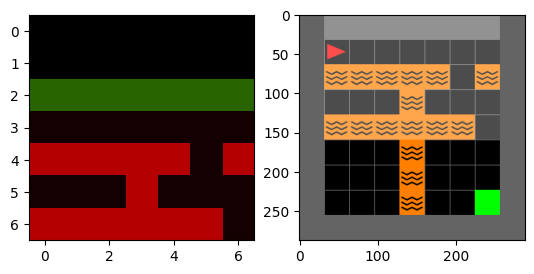

In [105]:
obs = env.reset()[0]

state = obs['image']*20
state = np.flip(state, axis=1)

plt.subplot(1, 2, 1)
plt.imshow(state)
plt.subplot(1, 2, 2)
plt.imshow(env.render())

0

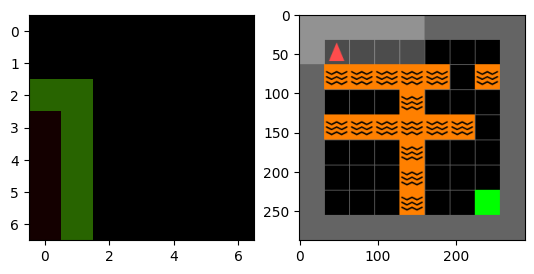

In [106]:
obs, rewards, *_ = env.step(0)

state = obs['image']*20
state = np.flip(state, axis=1)
# state = np.rot90(state, k=4-obs['direction'])

plt.subplot(1, 2, 1)
plt.imshow(state)
plt.subplot(1, 2, 2)
plt.imshow(env.render())
rewards

(0, False)

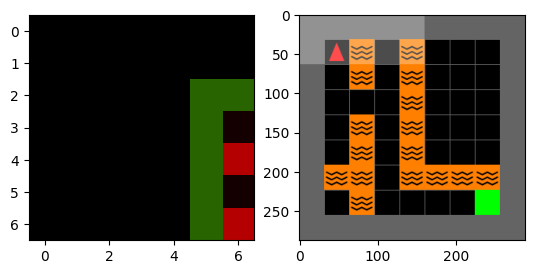

In [70]:
obs, rewards, rewards_tfm, terminated, truncated, info = env.step(2)
plt.subplot(1, 2, 1)
plt.imshow(obs*20)
plt.subplot(1, 2, 2)
plt.imshow(env.render())
rewards, terminated

In [2]:
import gymnasium as gym
import gym_agent as ga
from gymnasium.spaces import Dict, Box, Discrete
import numpy as np

In [3]:
class State_Tfm(ga.Transform):
    def __init__(self, n_envs):
        super().__init__()
        if n_envs <= 0:
            raise ValueError("n_envs should be greater than 0")
        elif n_envs == 1:
            envs = []
        else:
            envs = [n_envs]
        self.observation_space = Box(low=0, high=255, shape=(*envs, 7, 7, 3), dtype='uint8')

    def __call__(self, observation):
        return np.flip(observation['image'], axis=1)

In [5]:
a = ga.make_vec('MiniGrid-LavaCrossingS9N3-v0', 3, 3, vector_kwargs={'shared_memory': False})

In [6]:
a.set_observation_transform(State_Tfm(a.env.num_envs))

In [10]:
obs = a.reset()[0]

In [44]:
obs, rewards, terminated, truncated, info = a.step([2]*3)

terminated, truncated, info

(array([False, False,  True]),
 array([ True,  True, False]),
 {'final_observation': array([{'image': array([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
  
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
  
                [[0, 0, 0],
                 [0, 0, 0],
                 [2, 5, 0],
                 [2, 5, 0],
                 [2, 5, 0],
                 [2, 5, 0],
                 [2, 5, 0]],
  
                [[0, 0, 0],
                 [0, 0, 0],
                 [2, 5, 0],
                 [1, 0, 0],
                 [1, 0, 0],
                 [1, 0, 0],
                 [1, 0, 0]],
  
                [[0, 0, 0],
                 [0, 0, 0],
                 [2, 5, 0],
                 [9, 0,

In [89]:
class Temp(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, 3, 1, 1)
        self.bn = nn.BatchNorm2d(64)
        self.act = nn.ReLU(True)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, X):
        out = self.conv(X)
        out = self.bn(out)
        out = self.act(out)
        out = self.pool(out)
        return out

In [92]:
a = Temp()
a.to('cuda')

Temp(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [93]:
a(torch.randn(1, 3, 7, 7)).shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [36]:
import torch


In [37]:
a = torch.randn(64, 3, 8)

In [39]:
a[:, 1].shape

torch.Size([64, 8])

In [22]:
from stable_baselines3 import PPO
import gym_agent as ga
import torch
from gymnasium.spaces import MultiDiscrete

In [23]:
env = ga.make_vec("LunarLanderContinuous-v2", 2)

In [24]:
memory = ga.RolloutBuffer(1000000, env.observation_space, env.action_space, n_envs=env.num_envs)

In [19]:
class Action_Trasform(ga.Transform):
    def __init__(self):
        super().__init__()
        self.action_space = MultiDiscrete((2, 2, 3))
    
    def __call__(self, action):
        action[action < 0.5] = 0
        action[action >= 0.5] = 1
        return action

In [20]:
a.set_action_transform(Action_Trasform())

In [25]:
a.action_space.sample()

array([0, 1, 2])

In [21]:
model = PPO("MlpPolicy", a, verbose=1, device='cpu')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
dis, latent_pi = model.policy.evaluate_actions(torch.randn(1, 8), torch.Tensor([[0, 1]]))

In [26]:
model.policy.action_net(latent_pi)

tensor([[ 0.0026, -0.0055, -0.0017,  0.0024,  0.0034,  0.0065,  0.0065]],
       grad_fn=<AddmmBackward0>)

In [1]:
import psutil

In [2]:
psutil.virtual_memory().available

339660800

In [1]:
import numpy as np

In [11]:
a = np.random.randint(1, 2, (4, 5), dtype=np.bool_)
a[0][0] = False

In [12]:
a.all()

False

In [167]:
def swap_and_flatten(arr: np.ndarray) -> np.ndarray:
    """
    Swap and then flatten axes 0 (buffer_size) and 1 (n_envs)
    to convert shape from [n_steps, n_envs, ...] (when ... is the shape of the features)
    to [n_envs * n_steps, ...] (which maintain the order)
    """
    shape = arr.shape
    if len(shape) < 3:
        shape = (*shape, 1)
    return arr.swapaxes(0, 1).reshape(shape[0] * shape[1], *shape[2:])

In [189]:
a = np.random.randn(5, 2)

In [190]:
a

array([[ 0.7474188 ,  0.50710906],
       [ 1.12226375, -0.56650889],
       [-0.29135075, -0.35992246],
       [ 0.66748752,  0.63927737],
       [-0.79418967,  0.5960294 ]])

In [194]:
a[:, 1] = np.zeros(5)

In [195]:
a

array([[ 0.7474188 ,  0.        ],
       [ 1.12226375,  0.        ],
       [-0.29135075,  0.        ],
       [ 0.66748752,  0.        ],
       [-0.79418967,  0.        ]])

In [165]:
a[0][[True, False, True, False, True]]

array([0.7620229 , 0.82401632, 0.60260553])

In [14]:
isinstance({1:3}, dict)

True

In [3]:
from gymnasium.spaces import Dict, Discrete

In [4]:
a = Dict({"3": Discrete(3)})

In [7]:
a = {1: 3, 2: 4}

In [16]:
a.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

In [36]:
class Test:
    def __len__(self):
        return [1,2]

In [37]:
a = Test()

In [43]:
a.__len__()

[1, 2]

In [1]:
import torch

torch.cuda.is_available()

True

In [1]:
import numpy as np

In [32]:
a = np.zeros(1, dtype=bool)

In [33]:
b = {"a": a}

In [34]:
b

{'a': array([False])}

In [35]:
a[0] = True

In [36]:
b

{'a': array([ True])}

In [38]:
import gymnasium.spaces as spaces

In [45]:
spaces.Box(-1, 1, ( )).sample()

array(-0.6473554, dtype=float32)

In [118]:
import numpy as np
import math

In [119]:
a = np.zeros((2, 96, 96, 3))

In [120]:
a[0][0][0] = 5e-18

In [121]:
a[0][0][0]

array([5.e-18, 5.e-18, 5.e-18])

In [122]:
a[1][0][0] = 0.3

In [123]:
def allclose(a, b, rtol=1e-9, atol=0):
    # print(abs(a-b))
    # print(max(rtol * max(abs(a).max(), abs(b).max()), atol))
    return (abs(a - b) <= max(rtol * max(abs(a).max(), abs(b).max()), atol)).all()

In [124]:
isclose(a[0], a[1])

False

In [127]:
math.isclose(3+5e-17, 3)

True

In [1]:
a = lambda X=3: print(X)

In [3]:
a(4)

4


In [20]:
class Test:
    def hi(self, a):
        print(a)

In [25]:
class Test2(Test):
    def hi(self, b):
        print(b+1)

    def hi2(self, b):
        self.hi(b)
        super().hi(b)
    

In [26]:
a = Test2()

In [27]:
a.hi2(3)

4
3


In [28]:
a = None

In [29]:
hasattr(a, "hi")

False

In [1]:
from stable_baselines3 import PPO

pygame 2.5.2 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
PPO()

In [1]:
from tqdm.notebook import tqdm_notebook as tqdm
import time

In [4]:
loop = tqdm(range(100))
i = 0
loop.update(0)
while i <100:
    loop.update(1)
    time.sleep(3)
    if loop.n >= loop.total:
        loop.total += 1
    i += 1

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
loop = tqdm(range(100))
for i in loop:
    time.sleep(3)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 